# LSTM/GRU Model for Time-Series Classification 

## The purpose of the Task

* Recession Prediction: We will classify recession periods using some time-step window of feature data. Usually Time Series Classification problem is about classifying the whole time series data into certain label. So we will trying to create training dataset into time-step window size X and the last time-step y. In other words, we will use t=1~n(if time-step is n) X data to predict y(if recession or not) in t=n. 

* The bigger the time-step is, the smaller the number of observations is. The remaining number of observations will be (original #obs - time-step) 


* if batch_size=2, time-step=12, feature#=8, num_layer=1, n_classes=3, then

> lstm input is torch.Size([2, 12, 8])

> lstm output is torch.Size([1, 2, 50])

> linear layer output is  torch.Size([1, 2, 3])

> reshape output is torch.Size([2, 3])


## The structure of the Model

* LSTM / GRU layer: (batch_size, num_timestamp, num_feature) --> (num_layer, batch_size, hidden_size)

* dense layer: (num_layer, batch_size, hidden_size) --> (num_layer, batch_size, n_classes)

* reshape: (num_layer, batch_size, n_classes) --> (batch_size, n_classes)

* if it is multi class case (y_type=='y_agg')

> softmax & argmax: (batch_size, n_classes) --> (n_classes) --> class label(with largest probability value)

> use Cross Entropy Loss function

* if it is binary class case (y_type=='y_oecd) 

> sigmoid: (batch_size, n_classes) --> (n_classes) --> class label(with largest probability value)

> use Binary Entropy Loss function


In [14]:
## referring to SIADS642_Deep Learning material, change a code for time classification problem

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
## transform dataset with timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps ):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return torch.tensor(np.array(Xs)), torch.tensor(np.array(ys))

In [3]:
class RecModel_lstm(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size, num_layer, batch_first, dropout=0):
        super().__init__()
        self.n_features=n_features
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.batch_first=batch_first
        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size, 
                            num_layers=num_layer, 
                            dropout=dropout,
                            batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        out_x, (hidden, cell) = self.lstm(x)   ## for lstm
        out=hidden   ##[:,-1,:].reshape(-1)

        return self.linear(out)
    
    
class RecModel_gru(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size, num_layer, batch_first, dropout=0):
        super().__init__()
        self.n_features=n_features
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.batch_first=batch_first
        self.gru = nn.GRU(input_size=n_features, 
                            hidden_size=hidden_size, 
                            num_layers=num_layer, 
                            dropout=dropout,
                            batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        out_x, hidden = self.gru(x)   ## for lstm
        out=hidden   ##[:,-1,:].reshape(-1)
        
        return self.linear(out)

In [4]:
def train_loop(y_type, dataloader, model, loss_fn, optimizer, device):
    
    total = len(dataloader.dataset) # total number of examples
    num_data_seen = 0 # number of examples seen so far

    model.train() # Set your model to "train" mode

    for batch_idx, (X, y) in enumerate(dataloader):
        # Send inputs and labels to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
#        print('lstm input is', X.shape)
        
    
        if y_type=='y_agg':
            output = model(X) #.reshape(-1) # Reshape the pred of shape (N, 1) to (N,)
            output=torch.reshape(output, (output.size()[1],-1))
            y=y.long()
            loss = loss_fn(output, y)
            accuracy=(torch.softmax(output, dim=1).argmax(dim=1) == y).sum().float() / float( y.size(0) )

        else:
            output = model(X).reshape(-1)
            y=y.float()
            loss = loss_fn(torch.sigmoid(output), y)
            accuracy=((torch.sigmoid(output) >= 0.5) == y).sum().float() / float( y.size(0) )

#        print('linear layer output is ', output.shape)

    
#        print('reshape output is', output.shape)

        # Backpropagation
        optimizer.zero_grad() # You must zero grad before .backward!
        loss.backward()
        optimizer.step() # Take an optimization step

        num_data_seen += X.size(0)  ## batch size 만큼 num_data_seen이 증가하도록 함.
        # Print out stats every 20 batches
        if batch_idx % 6 == 0:
            loss = loss.item() # What is .item?
#            print(f"loss: {loss:>7f}  [{num_data_seen:>5d}/{total:>5d}]")
#            print(f"accuracy: {accuracy:>7f}  [{num_data_seen:>5d}/{total:>5d}]")

In [5]:
def test_loop(dataloader, model, loss_fn, device): # no more optimizer
    total = len(dataloader.dataset)
    test_loss = 0
    test_accuracy=0

    model.eval() # Set your model to "eval" mode

    with torch.no_grad():
        for X, y in dataloader: ##for each batch
            # Send inputs and labels to device
            X, y = X.to(device), y.to(device)
            
            
            if y_type=='y_agg':
                output = model(X) #.reshape(-1) # Reshape the pred of shape (N, 1) to (N,)
                output=torch.reshape(output, (output.size()[1],-1))
                y=y.long()
                loss = loss_fn(output, y)
                accuracy=(torch.softmax(output, dim=1).argmax(dim=1) == y).sum().float() / float( y.size(0) )

            else:
                output = model(X).reshape(-1)
                y=y.float()
                loss = loss_fn(torch.sigmoid(output), y)
                accuracy=((torch.sigmoid(output) >= 0.5) == y).sum().float() / float( y.size(0) )

#             output = model(X) # Reshape the pred of shape (N, 1) to (N,)
#             output=torch.reshape(output, (output.size()[1],-1))
#             y=y.long()

#             loss = loss_fn(output, y)
            
#             accuracy=(torch.softmax(output, dim=1).argmax(dim=1) == y).sum().float() / float( y.size(0) )

            # no more optimization steps            
            ## batch size=20이면, 20개 데이터당 하나의 loss가 계산되므로 loss*20을 해줌
            test_loss += loss.item() * X.size(0) # because "loss" was averaged over the batch
            test_accuracy += accuracy * X.size(0) # because "accuracy" was averaged over the batch

    ## loss의 합을 데이터 갯수로 나눠줌(평균)        
    test_loss /= total
    test_accuracy /= total
#    print(f"Avg test loss: {test_loss:>8f} \n")
#    print(f"Avg test accuracy: {test_accuracy:>8f} \n")

In [6]:
import os
import pickle
import pandas as pd
import numpy as np
from model_team14 import select_features, plot_pca, DTW, classification_report_csv

thresholds=[0.2, 0.3, 0.4, 0.5]   ##[0.2,0.3,0.4,0.5]
criterias=[None] 
time_steps=[18, 24]
batch_sizes=[5]
y_types = ['y_agg','y_oecd']
test_year = 5

model_names=['lstm']  ## two option: gru and lstm
hidden_sizes=[50,100]
num_layers=[1]
dropouts=[0]
num_epochs = [300,500]  ## just use 300

dict_nn={}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metadata=pd.read_csv('../data/full_info.csv')

## select imputed & transformed data
X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)


for threshold in thresholds:
    for criteria in criterias:
        
        path='../result/ft_{}_{}_nn'.format(str(criteria), str(threshold))

        if not os.path.exists(path):
            os.mkdir(path)

        ## filtering criteria is not cumulative explained variance ratio but just explained variance ratio
        df_feature=select_features(metadata, X, threshold, criteria=criteria)
        df_feature[df_feature.select==1]
        selected_features=list(df_feature[df_feature.select==1]['variable'])

        for y_type in y_types:
            
            if y_type=='y_agg':
                loss_fn = nn.CrossEntropyLoss()
            else:
                loss_fn = nn.BCELoss()

            
            for time_step in time_steps:
                X_data, y_data = create_dataset(X[selected_features], y[y_type], time_step)
                X_train=X_data[:-(test_year*12)]
                y_train=y_data[:-(test_year*12)]
                X_test=X_data[-(test_year*12):]
                y_test=y_data[-(test_year*12):]

                X_train = X_train.to(torch.float32)
                y_train = y_train.to(torch.float32)
                X_test = X_test.to(torch.float32)
                y_test = y_test.to(torch.float32)
                #X_train.shape, y_train.shape, X_test.shape, y_test.shape
                
                
                for batch_size in batch_sizes:

                    train_dataloader = DataLoader(list(zip(X_train,y_train)), batch_size=batch_size, shuffle=False)
                    test_dataloader = DataLoader(list(zip(X_test,y_test)), batch_size=batch_size, shuffle=False)

                    n_features=X_train.shape[-1]
                    
                    if y_type=='y_agg':
                        n_classes=len(torch.unique(y_train))
                    else:
                        n_classes=1
                        
                    batch_first=True
                    
                    for model_name in model_names:
                        for hidden_size in hidden_sizes:
                            for num_layer in num_layers:
                                for dropout in dropouts:

                                    if model_name=='lstm':
                                        model = RecModel_lstm(n_features=n_features, 
                                                     n_classes=n_classes,
                                                     hidden_size=hidden_size, 
                                                     num_layer=num_layer, 
                                                     dropout=dropout,
                                                     batch_first=batch_first).to(device)

                                    else:
                                        model = RecModel_gru(n_features=n_features, 
                                                     n_classes=n_classes,
                                                     hidden_size=hidden_size, 
                                                     num_layer=num_layer, 
                                                     dropout=dropout,
                                                     batch_first=batch_first).to(device)

                                    optimizer = optim.Adam(model.parameters(), lr=1e-3)   ##optim.Adam(model.parameters())

                                    print('start training & test!')
                                    for num_epoch in num_epochs:
                                        for t in range(num_epoch):
#                                            print(f"Epoch {t+1}\n-------------------------------")
                                            train_loop(y_type, train_dataloader, model, loss_fn, optimizer, device)
                                            test_loop(test_dataloader, model, loss_fn, device)
                                        print("model Done!")

                                        prediction=model(X_test).reshape((X_test.size(0),-1))
                
                                        if y_type=='y_agg':
                                            pred_prob=torch.softmax(prediction, dim=1)                        
                                            pred_label=torch.softmax(prediction, dim=1).argmax(dim=1)
                                        else:
                                            pred_prob=torch.sigmoid(prediction)
                                            pred_label=(torch.sigmoid(prediction)>=0.5)*1
                            
                                        clf_report=classification_report(np.array(y_test), np.array(pred_label))

                                        model_id='clf_{}_{}_{}_b{}_ep{}_h{}_n{}_dr{}'.format(model_name, y_type, time_step, batch_size, num_epoch, hidden_size,
                                                                                                         num_layer, dropout)

                                        with open (path+'/{}.pkl'.format(model_id),'wb') as f:
                                            pickle.dump([model, None, pred_label, pred_prob, clf_report], f)

                                        dict_nn[model_id]=[model, None, pred_label, pred_prob, clf_report]
                                
        
        for idx, model_id in enumerate(dict_nn.keys()):
            report=dict_nn[model_id][-1]

            if idx==0:
                df_nn_creport=classification_report_csv(report)
                df_nn_creport['model']=model_id
            else:
                df_tmp=classification_report_csv(report)
                df_tmp['model']=model_id
                df_nn_creport=pd.concat([df_nn_creport, df_tmp])
                
        with open (path+'/df_nn_creport.pkl', 'wb') as f:
            pickle.dump(df_nn_creport, f)


start training & test!
model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!
start training & test!
model Done!
model Done!


In [ ]:
thresholds=[0.2, 0.3, 0.4, 0.5]   ##[0.2,0.3,0.4,0.5]
criterias=[None] 
time_steps=[18, 24]
batch_sizes=[5]
y_types = ['y_agg','y_oecd']
test_year = 5



In [47]:
with open ('../result/ft_None_0.2_nn'+'/clf_lstm_y_agg_18_b5_ep300_h100_n1_dr0.pkl', 'rb') as f:
    [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)

In [57]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score,classification_report 
from sklearn.metrics import roc_curve, auc

labels=[0,1,2]
y_test_bin = label_binarize(y_test, classes=sorted(labels))
y_pred_prob[:,1].detach().numpy()

array([1.0370172e-05, 8.3111117e-05, 6.1126266e-05, 1.7603124e-05,
       2.0695838e-05, 9.4875768e-06, 2.2352181e-06, 3.3567746e-06,
       2.6169648e-06, 5.6055405e-06, 3.5017256e-06, 9.6821134e-07,
       2.5354771e-06, 3.7725638e-07, 4.8723650e-06, 6.9699627e-07,
       8.6650965e-07, 1.3534894e-06, 5.1727164e-07, 1.7601482e-06,
       6.6491979e-05, 8.1557989e-01, 9.9982578e-01, 9.9999285e-01,
       9.9999964e-01, 9.9999857e-01, 9.9999928e-01, 9.9967825e-01,
       9.9790514e-01, 9.8734879e-01, 9.9992073e-01, 1.1410760e-01,
       1.5041498e-04, 1.7001126e-05, 1.5065835e-06, 5.9690478e-07,
       7.9225185e-07, 3.4383672e-07, 4.1373059e-07, 5.7750742e-07,
       7.0635309e-07, 5.6115368e-08, 2.0241980e-07, 1.2769404e-07,
       1.9010321e-07, 1.7324720e-07, 8.2566470e-07, 2.6097249e-03,
       7.5242855e-03, 7.2439754e-01, 8.4766316e-01, 5.4279369e-01,
       6.2474895e-02, 2.9735693e-03, 7.6412647e-03, 2.4989216e-05,
       7.9008032e-07, 8.1021833e-05, 1.1349931e-01, 9.9937469e

In [32]:
with open ('../result/ft_None_0.5_nn/df_nn_creport.pkl', 'rb') as f:
    df_nn_creport=pickle.load(f)

In [33]:
df_nn_creport[df_nn_creport['class']>0].sort_values(['recall','f1_score'], ascending=[False, False])[:30]

,class,precision,recall,f1_score,support,accuracy,model
1,1.0,0.17,1.00,0.30,4.0,0.68,clf_lstm_y_oecd_24_b5_ep500_h100_n1_dr0
1,1.0,0.15,1.00,0.27,4.0,0.63,clf_lstm_y_oecd_18_b5_ep500_h100_n1_dr0
1,1.0,0.14,1.00,0.24,4.0,0.58,clf_lstm_y_oecd_18_b5_ep300_h50_n1_dr0
1,1.0,0.09,1.00,0.16,4.0,0.30,clf_lstm_y_oecd_24_b5_ep500_h50_n1_dr0
1,1.0,0.06,0.75,0.12,4.0,0.25,clf_lstm_y_oecd_24_b5_ep300_h50_n1_dr0
1,1.0,0.12,0.50,0.19,4.0,0.72,clf_lstm_y_oecd_18_b5_ep300_h100_n1_dr0
1,1.0,0.07,0.50,0.13,4.0,0.55,clf_lstm_y_oecd_18_b5_ep500_h50_n1_dr0
1,1.0,0.04,0.50,0.08,2.0,0.58,clf_lstm_y_agg_24_b5_ep500_h100_n1_dr0
1,1.0,0.03,0.50,0.06,2.0,0.40,clf_lstm_y_agg_24_b5_ep300_h100_n1_dr0
1,1.0,0.03,0.50,0.05,2.0,0.42,clf_lstm_y_agg_24_b5_ep300_h50_n1_dr0


NameError: name 'clf_lstm_y_oecd_6_b5_ep300_h50_n1_dr0' is not defined

In [ ]:
df_nn_creport[df_nn_creport['class']>0]

In [ ]:
a='/clf_lstm_y_oecd_6_b5_ep300_h50_n1_dr0'
a.split(".")[0].split("/")[-1]

In [ ]:
a=torch.tensor(np.array([-0.1,0.5,0.7]))
(torch.sigmoid(a)>=0.5)*1

In [ ]:
clf_lstm_y_agg_18_b5_ep300_h50_n1_dr0

In [ ]:
for idx, model in enumerate(dict_nn.keys()):
    
    report=dict_nn[model][-1]
    
    if idx==0:
        df_nn_creport=classification_report_csv(report)
        df_nn_creport['model']=model
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_nn_creport=pd.concat([df_nn_creport, df_tmp])
        
df_nn_creport[df_nn_creport['class']>0]

with open (path, 'wb') as f:
    df_nn_creport=pickle.load(f)

================================================

In [ ]:
# n_features=X_train.shape[-1]
# n_classes=len(torch.unique(y_train))
# hidden_size=50
# num_layer=1
# dropout=0
# batch_first=True
# num_epochs = 10
# model='gru'  ## two option: gru and lstm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# if model=='lstm':
#     model = RecModel_lstm(n_features=n_features, 
#                  n_classes=n_classes,
#                  hidden_size=hidden_size, 
#                  num_layer=num_layer, 
#                  dropout=0,
#                  batch_first=batch_first).to(device)

# else:
#     model = RecModel_gru(n_features=n_features, 
#                  n_classes=n_classes,
#                  hidden_size=hidden_size, 
#                  num_layer=num_layer, 
#                  dropout=0,
#                  batch_first=batch_first).to(device)

    
# loss_fn = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-3)   ##optim.Adam(model.parameters())


# for t in range(num_epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer, device)
#     test_loop(test_dataloader, model, loss_fn, device)
# print("Done!")

# with open (path+'/clf_{}_{}_{}_b{}_ep{}_h{}_n{}_dr{}.pkl'.format(model, y_type, time_step, batch_size, num_epochs, hidden_size,
#                                                                  num_layer, dropout), 'wb') as f:
#     pickle.dump([clf, df_cvresult, y_pred, y_pred_prob, clf_report], f)

In [69]:
y_test

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

date
2018-01-01    0.0
2018-02-01    0.0
2018-03-01    0.0
2018-04-01    0.0
2018-05-01    0.0
2018-06-01    0.0
2018-07-01    0.0
2018-08-01    0.0
2018-09-01    0.0
2018-10-01    0.0
2018-11-01    0.0
2018-12-01    0.0
2019-01-01    0.0
2019-02-01    0.0
2019-03-01    0.0
2019-04-01    0.0
2019-05-01    0.0
2019-06-01    0.0
2019-07-01    0.0
2019-08-01    0.0
2019-09-01    0.0
2019-10-01    0.0
2019-11-01    0.0
2019-12-01    0.0
2020-01-01    0.0
2020-02-01    1.0
2020-03-01    1.0
2020-04-01    1.0
2020-05-01    1.0
2020-06-01    0.0
2020-07-01    0.0
2020-08-01    0.0
2020-09-01    0.0
2020-10-01    0.0
2020-11-01    0.0
2020-12-01    0.0
2021-01-01    0.0
2021-02-01    0.0
2021-03-01    0.0
2021-04-01    0.0
2021-05-01    0.0
2021-06-01    0.0
2021-07-01    0.0
2021-08-01    0.0
2021-09-01    0.0
2021-10-01    0.0
2021-11-01    0.0
2021-12-01    0.0
2022-01-01    0.0
2022-02-01    0.0
2022-03-01    0.0
2022-04-01    0.0
2022-05-01    0.0
2022-06-01    0.0
2022-07-01    0.0
2022-

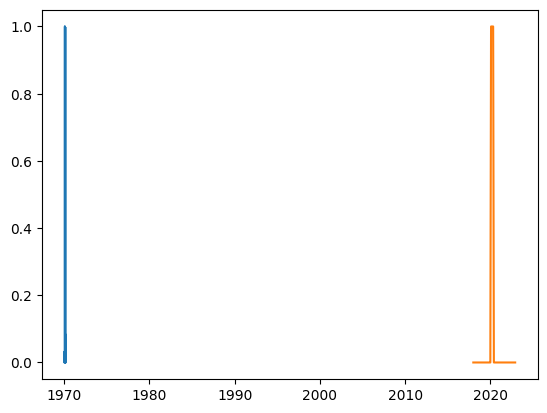

In [73]:
with open ('../result/ft_None_0.2_nn/clf_lstm_y_oecd_18_b5_ep300_h50_n1_dr0.pkl', 'rb') as f:
    [model, _, pred_label, pred_prob, clf_report]=pickle.load(f)


y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)



plt.plot(pred_prob.detach().numpy())
plt.plot(y_test)



In [67]:
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score,classification_report 
from sklearn.metrics import roc_curve, auc

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, pred_label)
print(cf_matrix)

[[50  6]
 [ 0  4]]


[[46  8  2]
 [ 0  2  2]
 [ 0  0  0]]


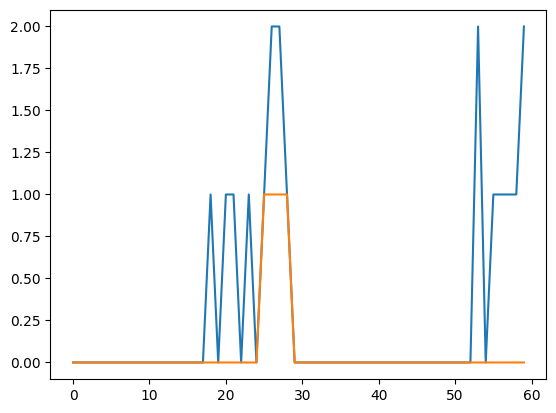

In [68]:
with open ('../result/ft_None_0.2/clf_rf_y_agg_tr_block_t5_spl3.pkl', 'rb') as f:
    [model, _, pred_label, pred_prob, clf_report]=pickle.load(f)

plt.plot(pred_label)
plt.plot(y_test)

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, pred_label)
print(cf_matrix)

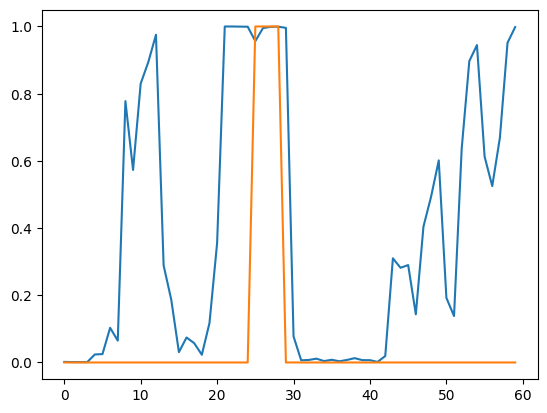

In [17]:
with open ('../result/ft_None_0.2_nn/clf_lstm_y_oecd_24_b5_ep300_h100_n1_dr0.pkl', 'rb') as f:
    [model, _, pred_label, pred_prob, clf_report]=pickle.load(f)

    
y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
y_test=y['oecd']
    
plt.plot(torch.sigmoid(prediction).detach().numpy())
plt.plot(y_test)

==============================================

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# pred_label=prediction.argmax(axis=1)

# prediction=model(X_test).detach().numpy()
# prediction=prediction.reshape((X_test.size(0),-1))

prediction=model(X_test).reshape((X_test.size(0),-1))

pred_label=torch.softmax(prediction, dim=1).argmax(dim=1)
pred_prob=torch.softmax(prediction, dim=1)

plt.plot(pred_label)
plt.plot(y_test)

np.argwhere(pred_label==2), np.argwhere(y_test==2)

pred_label==y_test

In [ ]:
# y_test

In [ ]:
# # plot

# import matplotlib.pyplot as plt

# train_size = len(y_train)

# with torch.no_grad():
#     # shift train predictions for plotting
#     train_plot = np.ones_like(timeseries) * np.nan
#     y_pred = model(X_train)
#     y_pred = y_pred[:, -1, :]
#     train_plot[lookback:train_size] = model(X_train)[:, -1, :]
#     # shift test predictions for plotting
#     test_plot = np.ones_like(timeseries) * np.nan
#     test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# # plot
# plt.plot(timeseries, c='b')
# plt.plot(train_plot, c='r')
# plt.plot(test_plot, c='g')
# plt.show()